In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [65]:
df = pd.read_csv('performance_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,url,screenshotpath,run
0,609 ms,2412 ms,15768 ms,0.147,21 ms,7114,3 KB,1305 ms,312,613,main_page,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_main_page_run1_21-04-18-40...,7
1,682 ms,2665 ms,12948 ms,0.414,25 ms,6152,3 KB,1587 ms,387,748,model_management,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_model_management_run1_21-0...,7
2,771 ms,2675 ms,12853 ms,0.322,20 ms,7568,3 KB,1596 ms,406,1724,app_management,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_app_management_run1_21-04-...,7
3,584 ms,2464 ms,12959 ms,0.107,19 ms,6044,3 KB,1512 ms,346,697,corpus_text_dataset,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_corpus_text_dataset_run1_2...,7
4,661 ms,2529 ms,12925 ms,0.080,31 ms,6631,3 KB,1582 ms,351,1529,knowledge_management,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_knowledge_management_run1_...,7


In [66]:
t_df = df.drop(['screenshotpath', 'run', 'url'], axis=1)
# t_df = df.columns.difference(['screenshotpath', 'url', 'run'])
t_df['host'] = df['url'].apply(lambda x: urlparse(x).netloc)
t_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,609 ms,2412 ms,15768 ms,0.147,21 ms,7114,3 KB,1305 ms,312,613,main_page,llmops.transwarp.io
1,682 ms,2665 ms,12948 ms,0.414,25 ms,6152,3 KB,1587 ms,387,748,model_management,llmops.transwarp.io
2,771 ms,2675 ms,12853 ms,0.322,20 ms,7568,3 KB,1596 ms,406,1724,app_management,llmops.transwarp.io
3,584 ms,2464 ms,12959 ms,0.107,19 ms,6044,3 KB,1512 ms,346,697,corpus_text_dataset,llmops.transwarp.io
4,661 ms,2529 ms,12925 ms,0.080,31 ms,6631,3 KB,1582 ms,351,1529,knowledge_management,llmops.transwarp.io


In [67]:
def clean_numeric(column):
    if column.dtype == 'object':
        return pd.to_numeric(column.str.replace(r'[^\d.]+', '', regex=True))
    else:
        return column

n_df = t_df.iloc[:, :10].apply(clean_numeric)
n_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements
0,609,2412,15768,0.147,21,7114,3,1305,312,613
1,682,2665,12948,0.414,25,6152,3,1587,387,748
2,771,2675,12853,0.322,20,7568,3,1596,406,1724
3,584,2464,12959,0.107,19,6044,3,1512,346,697
4,661,2529,12925,0.080,31,6631,3,1582,351,1529


In [68]:
from sklearn.preprocessing import MinMaxScaler

### 方法一(归一化)

In [69]:
scaler = MinMaxScaler()
s_df = pd.DataFrame(
    scaler.fit_transform(n_df),
    columns=t_df.columns[0:10]
)
s_df['pagename'] = t_df['pagename']
s_df['host'] = t_df['host']
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,0.670717,0.797692,0.895920,0.339492,0.545455,0.628047,1.0,0.436602,0.591304,0.027108,main_page,llmops.transwarp.io
1,0.759417,0.992308,0.679629,0.956120,0.727273,0.499196,1.0,0.612742,0.917391,0.108434,model_management,llmops.transwarp.io
2,0.867558,1.000000,0.672342,0.743649,0.500000,0.688856,1.0,0.618364,1.000000,0.696386,app_management,llmops.transwarp.io
3,0.640340,0.837692,0.680472,0.247113,0.454545,0.484731,1.0,0.565896,0.739130,0.077711,corpus_text_dataset,llmops.transwarp.io
4,0.733900,0.887692,0.677865,0.184758,1.000000,0.563354,1.0,0.609619,0.760870,0.578916,knowledge_management,llmops.transwarp.io


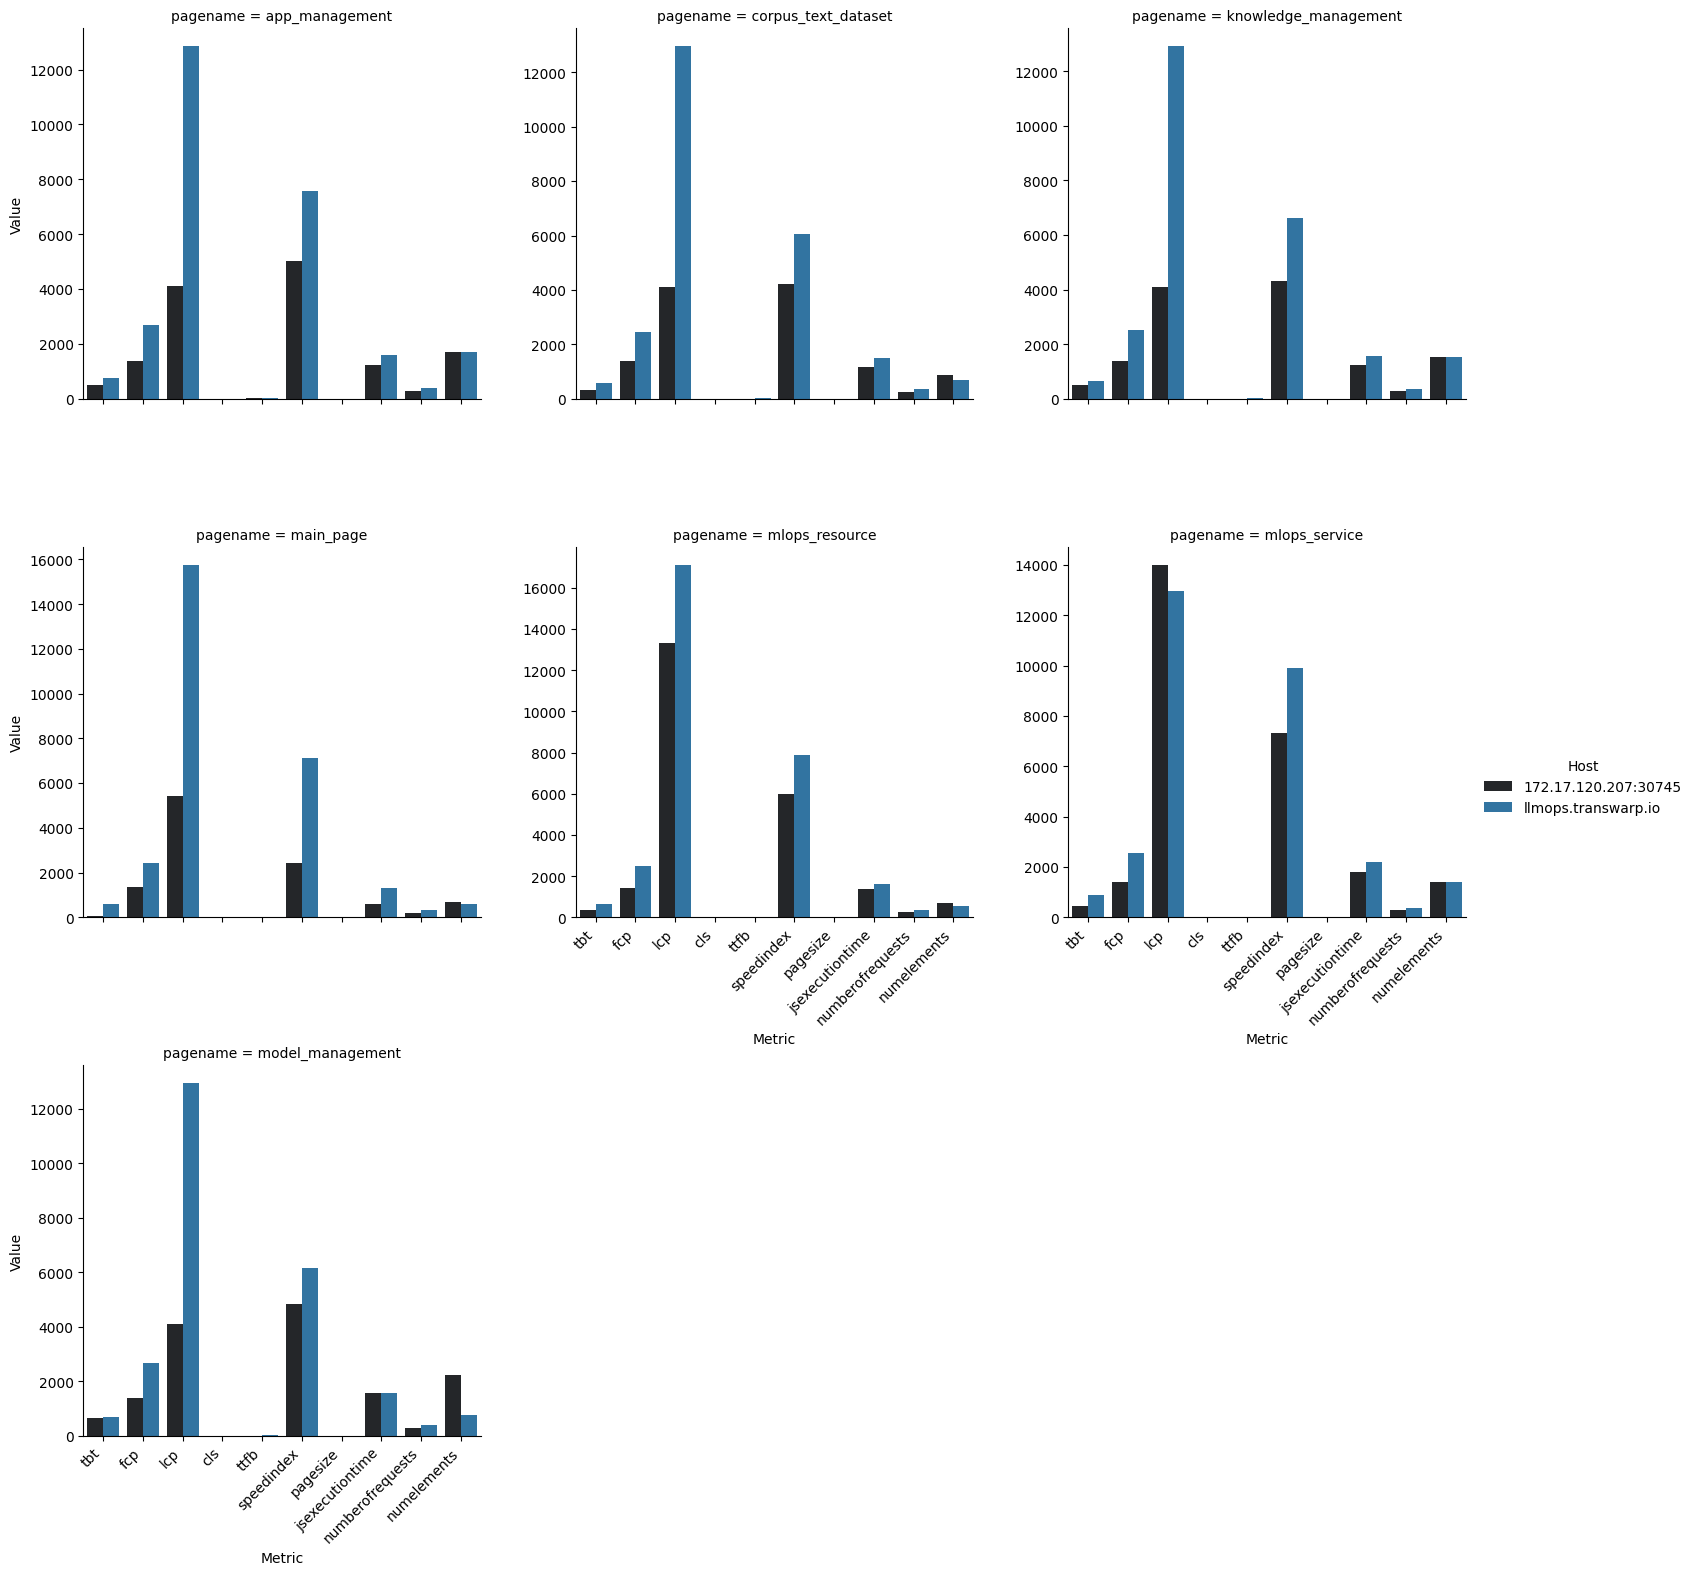

In [76]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
metric_order = m_df['Metric'].unique()
host_order = m_df['host'].unique()

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=5)
g.map(sns.barplot, 'Metric', 'Value', 'host', dodge=True, palette='dark:#1f77b4', order=metric_order, hue_order=host_order)

# 手动为每个子图设置 x 轴标签，只对最后三个有效, why?
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.add_legend(title='Host')
plt.subplots_adjust(hspace=0.4)
plt.savefig('normalization.png', dpi=300, bbox_inches='tight')
plt.show()

### 方法二(百分比)

In [71]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()


,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
9,503,1384,4102,0.255,14,5038,2,1237,296,1696,app_management,172.17.120.207:30745
2,771,2675,12853,0.322,20,7568,3,1596,406,1724,app_management,llmops.transwarp.io
10,312,1382,4096,0.000,9,4203,3,1177,267,875,corpus_text_dataset,172.17.120.207:30745
3,584,2464,12959,0.107,19,6044,3,1512,346,697,corpus_text_dataset,llmops.transwarp.io
11,493,1384,4087,0.000,11,4312,3,1223,272,1542,knowledge_management,172.17.120.207:30745


/tmp/ipykernel_3079/2057756127.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))


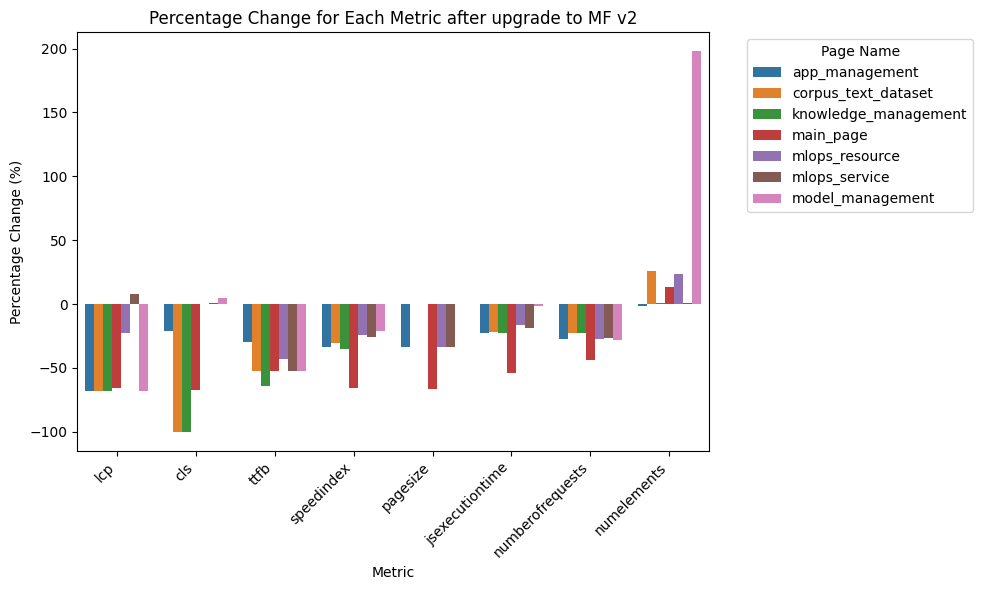

In [75]:
def percentage_change(df):
    row1, row2 = df.iloc[0], df.iloc[1]
    change = (row1 - row2) / row2.replace(0, 1) * 100
    return pd.Series(change, index=df.columns[2:])

g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))

m_df = g_df.reset_index().melt(id_vars='pagename', var_name='Metric', value_name='PercentageChange')
plt.figure(figsize=(10, 6))
sns.barplot(data=m_df, x='Metric', y='PercentageChange', hue='pagename')

plt.title('Percentage Change for Each Metric after upgrade to MF v2')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Page Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('percentage_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()